In [1]:
import pandas as pd

drug_df = pd.read_csv("Data/drug.csv")
drug_df = drug_df.sample(frac=1)
drug_df.head(3)

,Age,Sex,BP,Cholesterol,Na_to_K,Drug
144,39,M,HIGH,HIGH,9.664,drugA
68,54,M,NORMAL,HIGH,24.658,DrugY
86,51,F,NORMAL,HIGH,13.597,drugX


In [2]:
from sklearn.model_selection import train_test_split

X = drug_df.drop(columns=["Drug"]).to_numpy()
y = drug_df["Drug"].to_numpy()

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=125
)

In [3]:
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestClassifier
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OrdinalEncoder, StandardScaler

cat_col = [1,2,3]
num_col = [0,4]

transform = ColumnTransformer(
    [
        ("encoder", OrdinalEncoder(), cat_col),
        ("num_imputer", SimpleImputer(strategy="median"), num_col),
        ("num_scaler", StandardScaler(), num_col),
    ]
)
from tempfile import mkdtemp

# Specify a temporary directory for caching
cachedir = mkdtemp()

pipe = Pipeline(
    steps=[
        ("preprocessing", transform),
        ("model", RandomForestClassifier(
            n_estimators=10, 
            random_state=125, 
            min_samples_leaf=2,  # Added hyperparameter
            max_features="sqrt"  # Added hyperparameter
        )),
    ],
    memory=cachedir  # Enable caching
)
pipe.fit(X_train, y_train)

Pipeline(memory='C:\\Users\\venka\\AppData\\Local\\Temp\\tmp9qezzdcv',
         steps=[('preprocessing',
                 ColumnTransformer(transformers=[('encoder', OrdinalEncoder(),
                                                  [1, 2, 3]),
                                                 ('num_imputer',
                                                  SimpleImputer(strategy='median'),
                                                  [0, 4]),
                                                 ('num_scaler',
                                                  StandardScaler(), [0, 4])])),
                ('model',
                 RandomForestClassifier(min_samples_leaf=2, n_estimators=10,
                                        random_state=125))])

In [4]:
from sklearn.metrics import accuracy_score, f1_score

predictions = pipe.predict(X_test)
accuracy = accuracy_score(y_test, predictions)
f1 = f1_score(y_test, predictions, average="macro")

print("Accuracy: ", str(round(accuracy, 2) * 100) + "%", "F1: ", round(f1, 2))

Accuracy:  95.0% F1:  0.92


In [5]:
# Write metrics to file
with open("Results/metrics.txt", "w") as outfile:
    outfile.write(f"\nAccuracy = {round(accuracy,2)}, F1 Score = {round(f1,2)}.")

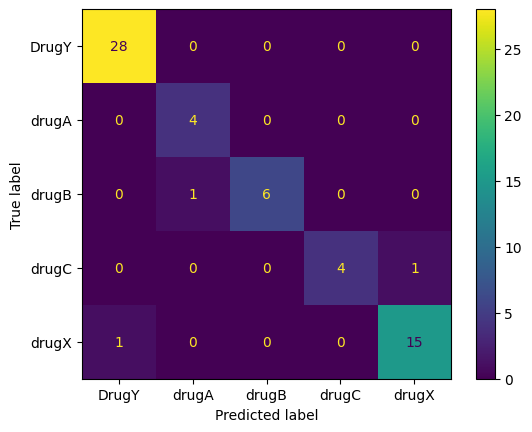

In [6]:
import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix

predictions = pipe.predict(X_test)
cm = confusion_matrix(y_test, predictions, labels=pipe.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=pipe.classes_)
disp.plot()
plt.savefig("Results/model_results.png", dpi=120)

In [9]:
from skops.io import dump, load, get_untrusted_types

# Define a constant for the model file path
MODEL_FILE_PATH = "Model/drug_pipeline.skops"

# Save and Load Model
dump(pipe, MODEL_FILE_PATH)
unknown_types = get_untrusted_types(file=MODEL_FILE_PATH)
loaded_pipe = load(MODEL_FILE_PATH, trusted=unknown_types)